# **MITRE ATT&CK PYTHON CLIENT**: Data Sources
------------------

## Goals:
* Access ATT&CK data sources in STIX format via a public TAXII server
* Learn to interact with ATT&CK data all at once
* Explore and idenfity patterns in the data retrieved
* Learn more about ATT&CK data sources

## 1. ATT&CK Python Client Installation

You can install it via PIP: **pip install attackcti**

## 2. Import ATT&CK API Client

In [1]:
from attackcti import attack_client

## 3. Import Extra Libraries

In [2]:
from pandas import *
from pandas.io.json import json_normalize

import numpy as np

import altair as alt
alt.renderers.enable('default')

import itertools


## 4. Initialize ATT&CK Client Class

In [3]:
lift = attack_client()

## 5. Getting Information About Techniques

Getting ALL ATT&CK Techniques

In [4]:
all_techniques = lift.get_all_techniques(stix_format=False)

Showing the first technique in our list

In [5]:
all_techniques[0]

{'external_references': [{'external_id': 'T1500',
   'source_name': 'mitre-attack',
   'url': 'https://attack.mitre.org/techniques/T1500'},
  {'url': 'https://www.clearskysec.com/wp-content/uploads/2018/11/MuddyWater-Operations-in-Lebanon-and-Oman.pdf',
   'source_name': 'ClearSky MuddyWater Nov 2018',
   'description': 'ClearSky Cyber Security. (2018, November). MuddyWater Operations in Lebanon and Oman: Using an Israeli compromised domain for a two-stage campaign. Retrieved November 29, 2018.'},
  {'url': 'https://blog.trendmicro.com/trendlabs-security-intelligence/windows-app-runs-on-mac-downloads-info-stealer-and-adware/',
   'source_name': 'TrendMicro WindowsAppMac',
   'description': 'Trend Micro. (2019, February 11). Windows App Runs on Mac, Downloads Info Stealer and Adware. Retrieved April 25, 2019.'}],
 'kill_chain_phases': [{'phase_name': 'defense-evasion',
   'kill_chain_name': 'mitre-attack'}],
 'x_mitre_version': '1.0',
 'url': 'https://attack.mitre.org/techniques/T1500',

Normalizing semi-structured JSON data into a flat table via **pandas.io.json.json_normalize**
* Reference: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html

In [6]:
techniques_normalized = json_normalize(all_techniques)

In [7]:
techniques_normalized[0:1]

,capec_id,capec_url,contributors,created,created_by_ref,data_sources,defense_bypassed,detectable_by_common_defenses,detectable_explanation,difficulty_explanation,...,tactic_type,technique,technique_description,technique_detection,technique_id,type,url,x_mitre_deprecated,x_mitre_old_attack_id,x_mitre_version
0,NaN,NaN,"[Ye Yint Min Thu Htut, Offensive Security Team...",2019-04-25T20:53:07.719Z,identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5,"[Process command-line parameters, Process moni...","[Static File Analysis, Binary Analysis, Anti-v...",NaN,NaN,NaN,...,NaN,Compile After Delivery,Adversaries may attempt to make payloads diffi...,Monitor the execution file paths and command-l...,T1500,attack-pattern,https://attack.mitre.org/techniques/T1500,NaN,NaN,1.0


## 6. Re-indexing Dataframe

In [8]:
techniques = techniques_normalized.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

In [9]:
techniques.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,"[Linux, macOS, Windows]",[defense-evasion],Compile After Delivery,T1500,"[Process command-line parameters, Process moni..."
1,mitre-attack,[Linux],[persistence],Systemd Service,T1501,"[Process command-line parameters, Process moni..."
2,mitre-attack,"[Linux, macOS, Windows]",[impact],Endpoint Denial of Service,T1499,"[SSL/TLS inspection, Web logs, Web application..."
3,mitre-attack,[Windows],"[defense-evasion, discovery]",Virtualization/Sandbox Evasion,T1497,"[Process monitoring, Process command-line para..."
4,mitre-attack,"[Linux, macOS, Windows]",[impact],Network Denial of Service,T1498,"[Sensor health and status, Network protocol an..."


In [10]:
print('A total of ',len(techniques),' techniques')

A total of  500  techniques


## 7. Removing Revoked Techniques

In [11]:
all_techniques_no_revoked = lift.remove_revoked(all_techniques)

In [12]:
print('A total of ',len(all_techniques_no_revoked),' techniques')

A total of  485  techniques


## 8. Extractinng Revoked Techniques

In [13]:
all_techniques_revoked = lift.extract_revoked(all_techniques)

In [14]:
print('A total of ',len(all_techniques_revoked),' techniques that have been revoked')

A total of  15  techniques that have been revoked


The revoked techniques are the following ones:

In [15]:
for t in all_techniques_revoked:
    print(t['technique'])

Remotely Install Application
Insecure Third-Party Libraries
Fake Developer Accounts
Detect App Analysis Environment
Malicious Software Development Tools
Biometric Spoofing
Device Unlock Code Guessing or Brute Force
Malicious Media Content
Abuse of iOS Enterprise App Signing Key
App Delivered via Web Download
App Delivered via Email Attachment
Malicious or Vulnerable Built-in Device Functionality
Malicious SMS Message
Exploit Baseband Vulnerability
Stolen Developer Credentials or Signing Keys


## 9. Updating our Dataframe

In [16]:
techniques_normalized = json_normalize(all_techniques_no_revoked)
techniques = techniques_normalized.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

## 10. Techniques Per Matrix
Using **altair** python library we can start showing a few charts stacking the number of techniques with or without data sources.
Reference: https://altair-viz.github.io/

In [17]:
data = techniques
data_2 = data.groupby(['matrix'])['technique'].count()
data_3 = data_2.to_frame().reset_index()
data_3

,matrix,technique
0,mitre-attack,244
1,mitre-mobile-attack,67
2,mitre-pre-attack,174


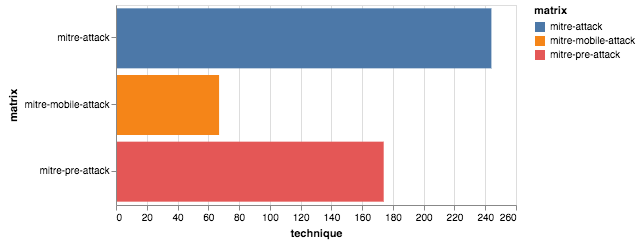

In [18]:
alt.Chart(data_3).mark_bar().encode(x='technique', y='matrix', color='matrix').properties(height = 200)

## 11. Techniques With and Without Data Sources

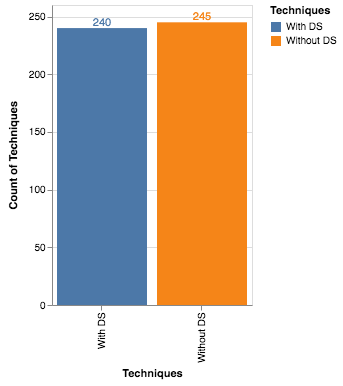

In [19]:
data_source_distribution = pandas.DataFrame({
    'Techniques': ['Without DS','With DS'],
    'Count of Techniques': [techniques['data_sources'].isna().sum(),techniques['data_sources'].notna().sum()]})
bars = alt.Chart(data_source_distribution).mark_bar().encode(x='Techniques',y='Count of Techniques',color='Techniques').properties(width=200,height=300)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

What is the distribution of techniques based on ATT&CK Matrix?

In [20]:
data = techniques
data['Count_DS'] = data['data_sources'].str.len()
data['Ind_DS'] = np.where(data['Count_DS']>0,'With DS','Without DS')
data_2 = data.groupby(['matrix','Ind_DS'])['technique'].count()
data_3 = data_2.to_frame().reset_index()
data_3

,matrix,Ind_DS,technique
0,mitre-attack,With DS,240
1,mitre-attack,Without DS,4
2,mitre-mobile-attack,Without DS,67
3,mitre-pre-attack,Without DS,174


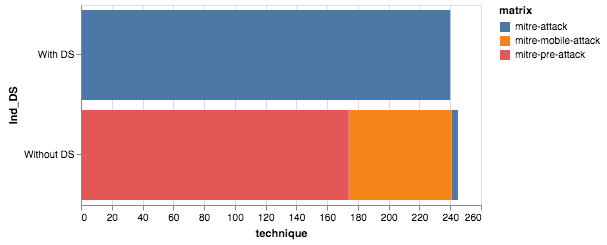

In [21]:
alt.Chart(data_3).mark_bar().encode(x='technique', y='Ind_DS', color='matrix').properties(height = 200)

What are those mitre-attack techniques without data sources?

In [22]:
data[(data['matrix']=='mitre-attack') & (data['Ind_DS']=='Without DS')]

,matrix,platform,tactic,technique,technique_id,data_sources,Count_DS,Ind_DS
52,mitre-attack,"[Linux, macOS]","[defense-evasion, persistence, command-and-con...",Port Knocking,T1205,NaN,NaN,Without DS
103,mitre-attack,[macOS],[defense-evasion],Gatekeeper Bypass,T1144,NaN,NaN,Without DS
106,mitre-attack,[macOS],[persistence],Re-opened Applications,T1164,NaN,NaN,Without DS
124,mitre-attack,[Windows],[discovery],Peripheral Device Discovery,T1120,NaN,NaN,Without DS


### Techniques without data sources

In [23]:
techniques_without_data_sources=techniques[techniques.data_sources.isnull()].reset_index(drop=True)

In [24]:
techniques_without_data_sources.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Count_DS,Ind_DS
0,mitre-attack,"[Linux, macOS]","[defense-evasion, persistence, command-and-con...",Port Knocking,T1205,NaN,NaN,Without DS
1,mitre-attack,[macOS],[defense-evasion],Gatekeeper Bypass,T1144,NaN,NaN,Without DS
2,mitre-attack,[macOS],[persistence],Re-opened Applications,T1164,NaN,NaN,Without DS
3,mitre-attack,[Windows],[discovery],Peripheral Device Discovery,T1120,NaN,NaN,Without DS
4,mitre-pre-attack,NaN,[technical-information-gathering],Spearphishing for Information,T1397,NaN,NaN,Without DS


In [25]:
print('There are ',techniques['data_sources'].isna().sum(),' techniques without data sources (',"{0:.0%}".format(techniques['data_sources'].isna().sum()/len(techniques)),' of ',len(techniques),' techniques)')

There are  245  techniques without data sources ( 51%  of  485  techniques)


### Techniques With Data Sources

In [26]:
techniques_with_data_sources=techniques[techniques.data_sources.notnull()].reset_index(drop=True)

In [27]:
techniques_with_data_sources.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Count_DS,Ind_DS
0,mitre-attack,"[Linux, macOS, Windows]",[defense-evasion],Compile After Delivery,T1500,"[Process command-line parameters, Process moni...",3.0,With DS
1,mitre-attack,[Linux],[persistence],Systemd Service,T1501,"[Process command-line parameters, Process moni...",3.0,With DS
2,mitre-attack,"[Linux, macOS, Windows]",[impact],Endpoint Denial of Service,T1499,"[SSL/TLS inspection, Web logs, Web application...",7.0,With DS
3,mitre-attack,[Windows],"[defense-evasion, discovery]",Virtualization/Sandbox Evasion,T1497,"[Process monitoring, Process command-line para...",2.0,With DS
4,mitre-attack,"[Linux, macOS, Windows]",[impact],Network Denial of Service,T1498,"[Sensor health and status, Network protocol an...",5.0,With DS


In [28]:
print('There are ',techniques['data_sources'].notna().sum(),' techniques with data sources (',"{0:.0%}".format(techniques['data_sources'].notna().sum()/len(techniques)),' of ',len(techniques),' techniques)')

There are  240  techniques with data sources ( 49%  of  485  techniques)


## 12. Grouping Techniques With Data Sources By Matrix

Let's create a graph to represent the number of techniques per matrix:

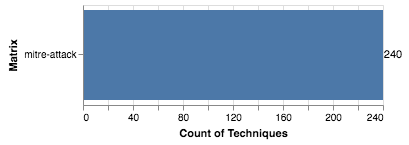

In [29]:
matrix_distribution = pandas.DataFrame({
    'Matrix': list(techniques_with_data_sources.groupby(['matrix'])['matrix'].count().keys()),
    'Count of Techniques': techniques_with_data_sources.groupby(['matrix'])['matrix'].count().tolist()})
bars = alt.Chart(matrix_distribution).mark_bar().encode(y='Matrix',x='Count of Techniques').properties(width=300,height=100)
text = bars.mark_text(align='center',baseline='middle',dx=10,dy=0).encode(text='Count of Techniques')
bars + text

All the techniques belong to **mitre-attack** matrix which is the main **Enterprise** matrix. Reference: https://attack.mitre.org/wiki/Main_Page 

## 13. Grouping Techniques With Data Sources by Platform

First, we need to split the **platform** column values because a technique might be mapped to more than one platform

In [30]:
techniques_platform=techniques_with_data_sources

attributes_1 = ['platform'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_1:
    s = techniques_platform.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_platform=techniques_platform.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_platform", and then join "techniques_platform" with "s"

# Let's re-arrange the columns from general to specific
techniques_platform_2=techniques_platform.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

We can now show techniques with data sources mapped to one platform at the time

In [31]:
techniques_platform_2.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,Linux,[defense-evasion],Compile After Delivery,T1500,"[Process command-line parameters, Process moni..."
1,mitre-attack,macOS,[defense-evasion],Compile After Delivery,T1500,"[Process command-line parameters, Process moni..."
2,mitre-attack,Windows,[defense-evasion],Compile After Delivery,T1500,"[Process command-line parameters, Process moni..."
3,mitre-attack,Linux,[persistence],Systemd Service,T1501,"[Process command-line parameters, Process moni..."
4,mitre-attack,Linux,[impact],Endpoint Denial of Service,T1499,"[SSL/TLS inspection, Web logs, Web application..."


Let's create a visualization to show the number of techniques grouped by platform:

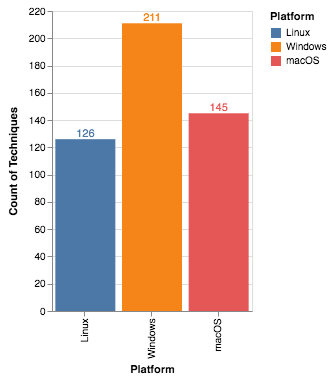

In [32]:
platform_distribution = pandas.DataFrame({
    'Platform': list(techniques_platform_2.groupby(['platform'])['platform'].count().keys()),
    'Count of Techniques': techniques_platform_2.groupby(['platform'])['platform'].count().tolist()})
bars = alt.Chart(platform_distribution,height=300).mark_bar().encode(x ='Platform',y='Count of Techniques',color='Platform').properties(width=200)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

In the bar chart above we can see that there are more techniques with data sources mapped to the Windows platform.

## 14. Grouping Techniques With Data Sources by Tactic

Again, first we need to split the tactic column values because a technique might be mapped to more than one tactic:

In [33]:
techniques_tactic=techniques_with_data_sources

attributes_2 = ['tactic'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_2:
    s = techniques_tactic.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_tactic = techniques_tactic.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_tactic", and then join "techniques_tactic" with "s"

# Let's re-arrange the columns from general to specific
techniques_tactic_2=techniques_tactic.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)


We can now show techniques with data sources mapped to one tactic at the time

In [34]:
techniques_tactic_2.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,"[Linux, macOS, Windows]",defense-evasion,Compile After Delivery,T1500,"[Process command-line parameters, Process moni..."
1,mitre-attack,[Linux],persistence,Systemd Service,T1501,"[Process command-line parameters, Process moni..."
2,mitre-attack,"[Linux, macOS, Windows]",impact,Endpoint Denial of Service,T1499,"[SSL/TLS inspection, Web logs, Web application..."
3,mitre-attack,[Windows],defense-evasion,Virtualization/Sandbox Evasion,T1497,"[Process monitoring, Process command-line para..."
4,mitre-attack,[Windows],discovery,Virtualization/Sandbox Evasion,T1497,"[Process monitoring, Process command-line para..."


Let's create a visualization to show the number of techniques grouped by tactic:

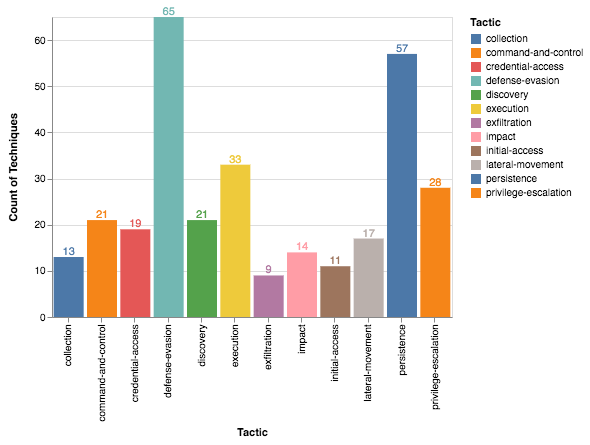

In [35]:
tactic_distribution = pandas.DataFrame({
    'Tactic': list(techniques_tactic_2.groupby(['tactic'])['tactic'].count().keys()),
    'Count of Techniques': techniques_tactic_2.groupby(['tactic'])['tactic'].count().tolist()}).sort_values(by='Count of Techniques',ascending=True)
bars = alt.Chart(tactic_distribution,width=800,height=300).mark_bar().encode(x ='Tactic',y='Count of Techniques',color='Tactic').properties(width=400)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

Defende-evasion and Persistence are tactics with the highest nummber of techniques with data sources

## 15. Grouping Techniques With Data Sources by Data Source

We need to split the data source column values because a technique might be mapped to more than one data source:

In [36]:
techniques_data_source=techniques_with_data_sources

attributes_3 = ['data_sources'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_3:
    s = techniques_data_source.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_data_source = techniques_data_source.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_data_source", and then join "techniques_data_source" with "s"

# Let's re-arrange the columns from general to specific
techniques_data_source_2 = techniques_data_source.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

# We are going to edit some names inside the dataframe to improve the consistency:
techniques_data_source_3 = techniques_data_source_2.replace(['Process monitoring','Application logs'],['Process Monitoring','Application Logs'])

We can now show techniques with data sources mapped to one data source at the time

In [37]:
techniques_data_source_3.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,"[Linux, macOS, Windows]",[defense-evasion],Compile After Delivery,T1500,Process command-line parameters
1,mitre-attack,"[Linux, macOS, Windows]",[defense-evasion],Compile After Delivery,T1500,Process Monitoring
2,mitre-attack,"[Linux, macOS, Windows]",[defense-evasion],Compile After Delivery,T1500,File monitoring
3,mitre-attack,[Linux],[persistence],Systemd Service,T1501,Process command-line parameters
4,mitre-attack,[Linux],[persistence],Systemd Service,T1501,Process Monitoring


Let's create a visualization to show the number of techniques grouped by data sources:

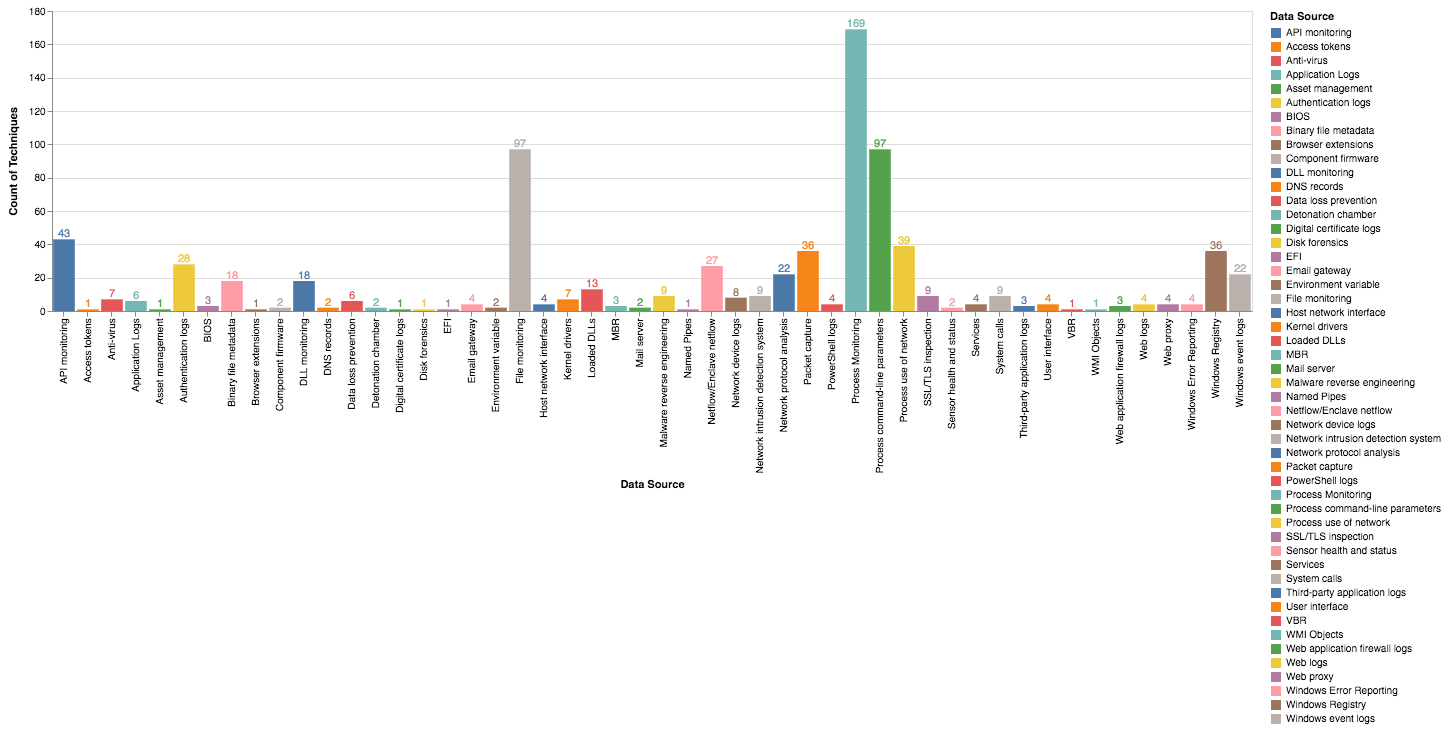

In [38]:
data_source_distribution = pandas.DataFrame({
    'Data Source': list(techniques_data_source_3.groupby(['data_sources'])['data_sources'].count().keys()),
    'Count of Techniques': techniques_data_source_3.groupby(['data_sources'])['data_sources'].count().tolist()})
bars = alt.Chart(data_source_distribution,width=800,height=300).mark_bar().encode(x ='Data Source',y='Count of Techniques',color='Data Source').properties(width=1200)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

A few interesting things from the bar chart above:
* Process Monitoring, File Monitoring, and Process Command-line parameters are the Data Sources with the highest number of techniques
* There are some data source names that include string references to Windows such as PowerShell, Windows and wmi

## 16. Most Relevant Groups Of Data Sources Per Technique

### Number Of Data Sources Per Technique

Although identifying the data sources with the highest number of techniques is a good start, they usually do not work alone. You might be collecting **Process Monitoring** already but you might be still missing a lot of context from a data perspective.

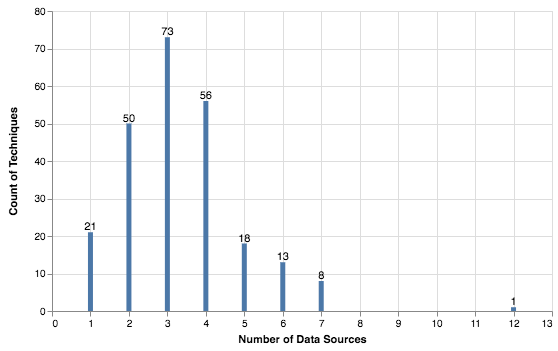

In [39]:
data_source_distribution_2 = pandas.DataFrame({
    'Techniques': list(techniques_data_source_3.groupby(['technique'])['technique'].count().keys()),
    'Count of Data Sources': techniques_data_source_3.groupby(['technique'])['technique'].count().tolist()})

data_source_distribution_3 = pandas.DataFrame({
    'Number of Data Sources': list(data_source_distribution_2.groupby(['Count of Data Sources'])['Count of Data Sources'].count().keys()),
    'Count of Techniques': data_source_distribution_2.groupby(['Count of Data Sources'])['Count of Data Sources'].count().tolist()})

bars = alt.Chart(data_source_distribution_3).mark_bar().encode(x ='Number of Data Sources',y='Count of Techniques').properties(width=500)
text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
bars + text

The image above shows you the number data sources needed per techniques according to ATT&CK:
* There are 71 techniques that require 3 data sources as enough context to validate the detection of them according to ATT&CK
* Only one technique has 12 data sources
* One data source only applies to 19 techniques

Let's create subsets of data sources with the data source column defining and using a python function:

In [40]:
# https://stackoverflow.com/questions/26332412/python-recursive-function-to-display-all-subsets-of-given-set
def subs(l):
    res = []
    for i in range(1, len(l) + 1):
        for combo in itertools.combinations(l, i):
            res.append(list(combo))
    return res

Before applying the function, we need to use lowercase data sources names and sort data sources names to improve consistency:

In [41]:
df = techniques_with_data_sources[['data_sources']]

In [42]:
for index, row in df.iterrows():
    row["data_sources"]=[x.lower() for x in row["data_sources"]]
    row["data_sources"].sort()

In [43]:
df.head()

,data_sources
0,"[file monitoring, process command-line paramet..."
1,"[file monitoring, process command-line paramet..."
2,"[netflow/enclave netflow, network device logs,..."
3,"[process command-line parameters, process moni..."
4,"[netflow/enclave netflow, network device logs,..."


Let's apply the function and split the subsets column:

In [44]:
df['subsets']=df['data_sources'].apply(subs)

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
df.head()

,data_sources,subsets
0,"[file monitoring, process command-line paramet...","[[file monitoring], [process command-line para..."
1,"[file monitoring, process command-line paramet...","[[file monitoring], [process command-line para..."
2,"[netflow/enclave netflow, network device logs,...","[[netflow/enclave netflow], [network device lo..."
3,"[process command-line parameters, process moni...","[[process command-line parameters], [process m..."
4,"[netflow/enclave netflow, network device logs,...","[[netflow/enclave netflow], [network device lo..."


We need to split the subsets column values:

In [46]:
techniques_with_data_sources_preview = df

In [47]:
attributes_4 = ['subsets']

for a in attributes_4:
    s = techniques_with_data_sources_preview.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    s.name = a
    techniques_with_data_sources_preview = techniques_with_data_sources_preview.drop(a, axis=1).join(s).reset_index(drop=True)
    
techniques_with_data_sources_subsets = techniques_with_data_sources_preview.reindex(['data_sources','subsets'], axis=1)


In [48]:
techniques_with_data_sources_subsets.head()

,data_sources,subsets
0,"[file monitoring, process command-line paramet...",[file monitoring]
1,"[file monitoring, process command-line paramet...",[process command-line parameters]
2,"[file monitoring, process command-line paramet...",[process monitoring]
3,"[file monitoring, process command-line paramet...","[file monitoring, process command-line paramet..."
4,"[file monitoring, process command-line paramet...","[file monitoring, process monitoring]"


Let's add three columns to analyse the dataframe: subsets_name (Changing Lists to Strings), subsets_number_elements ( Number of data sources per subset) and number_data_sources_per_technique

In [49]:
techniques_with_data_sources_subsets['subsets_name']=techniques_with_data_sources_subsets['subsets'].apply(lambda x: ','.join(map(str, x)))
techniques_with_data_sources_subsets['subsets_number_elements']=techniques_with_data_sources_subsets['subsets'].str.len()
techniques_with_data_sources_subsets['number_data_sources_per_technique']=techniques_with_data_sources_subsets['data_sources'].str.len()

In [50]:
techniques_with_data_sources_subsets.head()

,data_sources,subsets,subsets_name,subsets_number_elements,number_data_sources_per_technique
0,"[file monitoring, process command-line paramet...",[file monitoring],file monitoring,1,3
1,"[file monitoring, process command-line paramet...",[process command-line parameters],process command-line parameters,1,3
2,"[file monitoring, process command-line paramet...",[process monitoring],process monitoring,1,3
3,"[file monitoring, process command-line paramet...","[file monitoring, process command-line paramet...","file monitoring,process command-line parameters",2,3
4,"[file monitoring, process command-line paramet...","[file monitoring, process monitoring]","file monitoring,process monitoring",2,3


As it was described above, we need to find grups pf data sources, so we are going to filter out all the subsets with only one data source:

In [51]:
subsets = techniques_with_data_sources_subsets

subsets_ok=subsets[subsets.subsets_number_elements != 1]

In [52]:
subsets_ok.head()

,data_sources,subsets,subsets_name,subsets_number_elements,number_data_sources_per_technique
3,"[file monitoring, process command-line paramet...","[file monitoring, process command-line paramet...","file monitoring,process command-line parameters",2,3
4,"[file monitoring, process command-line paramet...","[file monitoring, process monitoring]","file monitoring,process monitoring",2,3
5,"[file monitoring, process command-line paramet...","[process command-line parameters, process moni...","process command-line parameters,process monito...",2,3
6,"[file monitoring, process command-line paramet...","[file monitoring, process command-line paramet...","file monitoring,process command-line parameter...",3,3
10,"[file monitoring, process command-line paramet...","[file monitoring, process command-line paramet...","file monitoring,process command-line parameters",2,3


Finally, we calculate the most relevant groups of data sources (Top 15):

In [53]:
subsets_graph = subsets_ok.groupby(['subsets_name'])['subsets_name'].count().to_frame(name='subsets_count').sort_values(by='subsets_count',ascending=False)[0:15]

In [54]:
subsets_graph

,subsets_count
subsets_name,
"process command-line parameters,process monitoring",88
"file monitoring,process monitoring",74
"file monitoring,process command-line parameters",49
"file monitoring,process command-line parameters,process monitoring",42
"process monitoring,process use of network",33
"api monitoring,process monitoring",32
"process monitoring,windows registry",29
"packet capture,process use of network",21
"packet capture,process monitoring",19


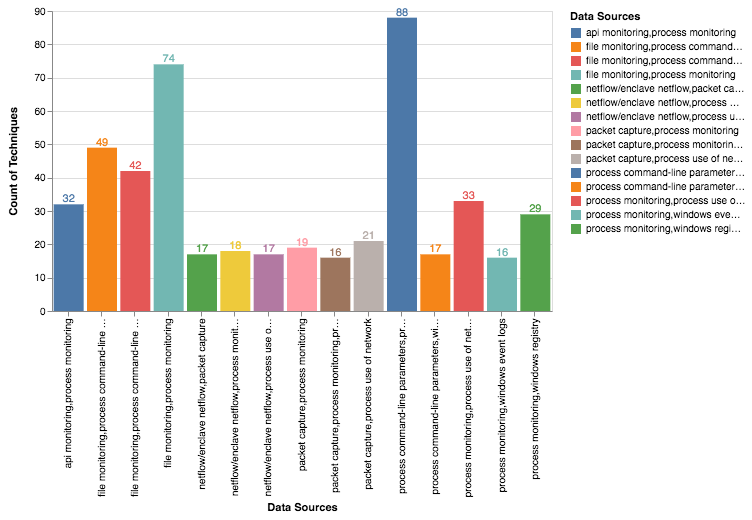

In [55]:
subsets_graph_2 = pandas.DataFrame({
    'Data Sources': list(subsets_graph.index),
    'Count of Techniques': subsets_graph['subsets_count'].tolist()})

bars = alt.Chart(subsets_graph_2).mark_bar().encode(x ='Data Sources', y ='Count of Techniques', color='Data Sources').properties(width=500)
text = bars.mark_text(align='center',baseline='middle',dx= 0,dy=-5).encode(text='Count of Techniques')
bars + text

Group (Process Monitoring - Process Command-line parameters) is the is the group of data sources with the highest number of techniques. This group of data sources are suggested to hunt 78 techniques

## 17. Let's Split all the Information About Techniques With Data Sources Defined: Matrix, Platform, Tactic and Data Source

Let's split all the relevant columns of the dataframe:

In [56]:
techniques_data = techniques_with_data_sources

attributes = ['platform','tactic','data_sources'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes:
    s = techniques_data.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_data=techniques_data.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_data", and then join "techniques_data" with "s"

# Let's re-arrange the columns from general to specific
techniques_data_2=techniques_data.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

# We are going to edit some names inside the dataframe to improve the consistency:
techniques_data_3 = techniques_data_2.replace(['Process monitoring','Application logs'],['Process Monitoring','Application Logs'])

techniques_data_3.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,Linux,defense-evasion,Compile After Delivery,T1500,Process command-line parameters
1,mitre-attack,Linux,defense-evasion,Compile After Delivery,T1500,Process Monitoring
2,mitre-attack,Linux,defense-evasion,Compile After Delivery,T1500,File monitoring
3,mitre-attack,macOS,defense-evasion,Compile After Delivery,T1500,Process command-line parameters
4,mitre-attack,macOS,defense-evasion,Compile After Delivery,T1500,Process Monitoring


Do you remember data sources names with a reference to Windows? After splitting the dataframe by platforms, tactics and data sources, are there any macOC or linux techniques that consider windows data sources? Let's identify those rows:

In [57]:
# After splitting the rows of the dataframe, there are some values that relate windows data sources with platforms like linux and masOS.
# We need to identify those rows
conditions = [(techniques_data_3['platform']=='Linux')&(techniques_data_3['data_sources'].str.contains('windows',case=False)== True),
             (techniques_data_3['platform']=='macOS')&(techniques_data_3['data_sources'].str.contains('windows',case=False)== True),
             (techniques_data_3['platform']=='Linux')&(techniques_data_3['data_sources'].str.contains('powershell',case=False)== True),
             (techniques_data_3['platform']=='macOS')&(techniques_data_3['data_sources'].str.contains('powershell',case=False)== True),
             (techniques_data_3['platform']=='Linux')&(techniques_data_3['data_sources'].str.contains('wmi',case=False)== True),
             (techniques_data_3['platform']=='macOS')&(techniques_data_3['data_sources'].str.contains('wmi',case=False)== True)]
# In conditions we indicate a logical test

choices = ['NO OK','NO OK','NO OK','NO OK','NO OK','NO OK']
# In choices, we indicate the result when the logical test is true

techniques_data_3['Validation'] = np.select(conditions,choices,default='OK')
# We add a column "Validation" to "techniques_data_3" with the result of the logical test. The default value is going to be "OK"

What is the inconsistent data?

In [58]:
techniques_analysis_data_no_ok = techniques_data_3[techniques_data_3.Validation == 'NO OK']
# Finally, we are filtering all the values with NO OK

techniques_analysis_data_no_ok.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Validation
105,mitre-attack,macOS,impact,Inhibit System Recovery,T1490,Windows Registry,NO OK
107,mitre-attack,macOS,impact,Inhibit System Recovery,T1490,Windows event logs,NO OK
110,mitre-attack,Linux,impact,Inhibit System Recovery,T1490,Windows Registry,NO OK
112,mitre-attack,Linux,impact,Inhibit System Recovery,T1490,Windows event logs,NO OK
187,mitre-attack,Linux,defense-evasion,File Permissions Modification,T1222,Windows event logs,NO OK


In [59]:
print('There are ',len(techniques_analysis_data_no_ok),' rows with inconsistent data')

There are  37  rows with inconsistent data


What is the impact of this inconsistent data from a platform and data sources perspective?

In [60]:
df = techniques_with_data_sources

attributes = ['platform','data_sources']

for a in attributes:
    s = df.apply(lambda x: pandas.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    s.name = a
    df=df.drop(a, axis=1).join(s).reset_index(drop=True)
    
df_2=df.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)
df_3 = df_2.replace(['Process monitoring','Application logs'],['Process Monitoring','Application Logs'])

conditions = [(df_3['data_sources'].str.contains('windows',case=False)== True),
              (df_3['data_sources'].str.contains('powershell',case=False)== True),
              (df_3['data_sources'].str.contains('wmi',case=False)== True)]

choices = ['Windows','Windows','Windows']

df_3['Validation'] = np.select(conditions,choices,default='Other')
df_3['Num_Tech'] = 1
df_4 = df_3[df_3.Validation == 'Windows']
df_5 = df_4.groupby(['data_sources','platform'])['technique'].nunique()
df_6 = df_5.to_frame().reset_index()

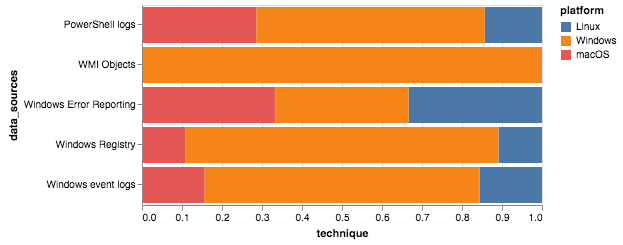

In [61]:
alt.Chart(df_6).mark_bar().encode(x=alt.X('technique', stack="normalize"),    y='data_sources',    color='platform').properties(height=200)

There are techniques that consider Windows Error Reporting, Windows Registry, and Windows event logs as data sources and they also consider platforms like Linux and masOS. We do not need to consider this rows because those data sources can only be managed at a Windows environment. These are the techniques that we should not consider in our data base:

In [62]:
techniques_analysis_data_no_ok[['technique','data_sources']].drop_duplicates().sort_values(by='data_sources',ascending=True)

,technique,data_sources
666,Input Prompt,PowerShell logs
1990,Credential Dumping,PowerShell logs
306,Exploitation for Defense Evasion,Windows Error Reporting
315,Exploitation of Remote Services,Windows Error Reporting
388,Exploitation for Credential Access,Windows Error Reporting
1384,Exploitation for Privilege Escalation,Windows Error Reporting
105,Inhibit System Recovery,Windows Registry
1182,Disabling Security Tools,Windows Registry
1311,Third-party Software,Windows Registry
1480,Input Capture,Windows Registry


Without considering this inconsistent data, the final dataframe is:

In [63]:
techniques_analysis_data_ok = techniques_data_3[techniques_data_3.Validation == 'OK']
techniques_analysis_data_ok.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Validation
0,mitre-attack,Linux,defense-evasion,Compile After Delivery,T1500,Process command-line parameters,OK
1,mitre-attack,Linux,defense-evasion,Compile After Delivery,T1500,Process Monitoring,OK
2,mitre-attack,Linux,defense-evasion,Compile After Delivery,T1500,File monitoring,OK
3,mitre-attack,macOS,defense-evasion,Compile After Delivery,T1500,Process command-line parameters,OK
4,mitre-attack,macOS,defense-evasion,Compile After Delivery,T1500,Process Monitoring,OK


In [64]:
print('There are ',len(techniques_analysis_data_ok),' rows of data that you can play with')

There are  1983  rows of data that you can play with


## 18. Getting Techniques by Data Sources

This function gets techniques' information that includes specific data sources

In [65]:
data_source = 'PROCESS MONITORING'

In [66]:
results = lift.get_techniques_by_datasources(data_source)

In [67]:
len(results)

169

In [74]:
type(results)

list

In [68]:
data_sources_list = ['pRoceSS MoniTorinG','process commAnd-linE parameters']

In [69]:
results2 = lift.get_techniques_by_datasources(data_sources_list)

In [70]:
len(results2)

178

In [71]:
results2[1]

AttackPattern(type='attack-pattern', id='attack-pattern--0fff2797-19cb-41ea-a5f1-8a9303b8158e', created_by_ref='identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5', created='2019-04-23T15:34:30.008Z', modified='2019-04-29T14:14:08.450Z', name='Systemd Service', description="Systemd services can be used to establish persistence on a Linux system. The systemd service manager is commonly used for managing background daemon processes (also known as services) and other system resources.(Citation: Linux man-pages: systemd January 2014)(Citation: Freedesktop.org Linux systemd 29SEP2018) Systemd is the default initialization (init) system on many Linux distributions starting with Debian 8, Ubuntu 15.04, CentOS 7, RHEL 7, Fedora 15, and replaces legacy init systems including SysVinit and Upstart while remaining backwards compatible with the aforementioned init systems.\n\nSystemd utilizes configuration files known as service units to control how services boot and under what conditions. By default, 